In [31]:
import sys, os
sys.path.append("..")
sys.path.append("../src")

import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

from src.data.dataset_pairs import UpscaleDataset

In [32]:
dataset = UpscaleDataset(
    lr_dir="../data/train_lr",
    hr_dir="../data/train_hr",
)

print("Dataset size:", len(dataset))

# 抽第一張來看
lr, hr = dataset[0]
print("LR shape:", lr.shape)
print("HR shape:", hr.shape)

Found 492 image pairs.
Dataset size: 492
LR shape: torch.Size([3, 64, 64])
HR shape: torch.Size([3, 256, 256])


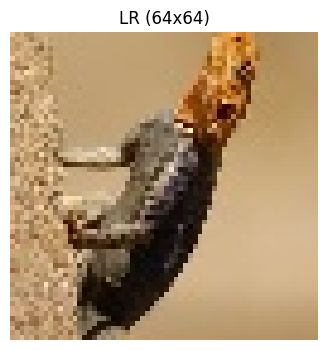

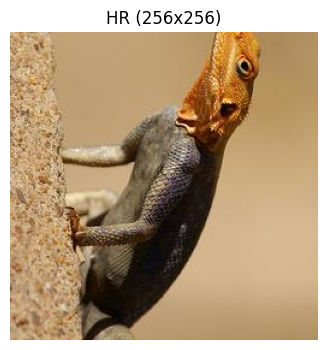

In [33]:
def show_tensor(img, title=""):
    img_np = img.permute(1, 2, 0).numpy()  # CHW → HWC
    plt.figure(figsize=(4,4))
    plt.imshow(img_np)
    plt.title(title)
    plt.axis("off")
    plt.show()

show_tensor(lr, "LR (64x64)")
show_tensor(hr, "HR (256x256)")

In [34]:
def upscale_bicubic(lr_tensor, scale_factor=4):
    """
    lr_tensor: (3, H, W) in [0,1]
    回傳: (3, H*4, W*4)
    """
    x = lr_tensor.unsqueeze(0)  # (1,3,H,W)
    x_up = F.interpolate(x, scale_factor=scale_factor, mode="bicubic", align_corners=False)
    return x_up.squeeze(0)

def upscale_nearest(lr_tensor, scale_factor=4):
    x = lr_tensor.unsqueeze(0)
    x_up = F.interpolate(x, scale_factor=scale_factor, mode="nearest")
    return x_up.squeeze(0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.11243127..1.0545386].


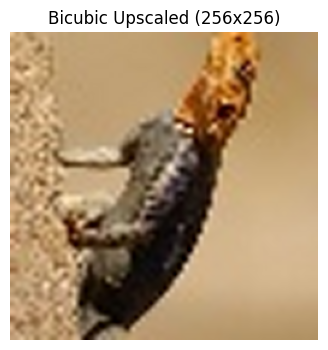

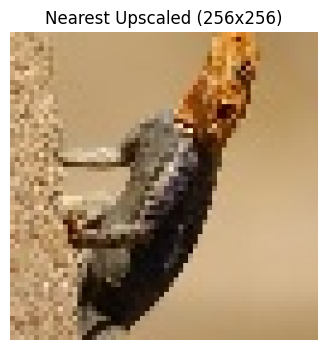

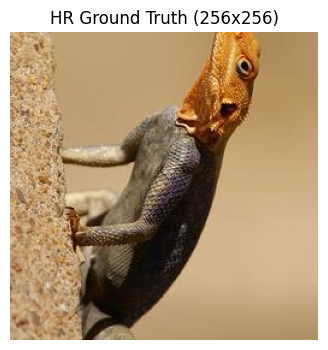

In [35]:
bicubic = upscale_bicubic(lr)
nearest = upscale_nearest(lr)

show_tensor(bicubic, "Bicubic Upscaled (256x256)")
show_tensor(nearest, "Nearest Upscaled (256x256)")
show_tensor(hr, "HR Ground Truth (256x256)")

In [36]:
import math

def psnr(img1, img2):
    """
    img1, img2: torch.Tensor, shape (3,H,W), 值域 [0,1]
    """
    mse = torch.mean((img1 - img2) ** 2).item()
    if mse == 0:
        return float("inf")
    return 10 * math.log10(1.0 / mse)

In [37]:
bicubic_psnr = psnr(bicubic, hr)
nearest_psnr = psnr(nearest, hr)

print(f"PSNR (Bicubic vs HR): {bicubic_psnr:.2f} dB")
print(f"PSNR (Nearest vs HR): {nearest_psnr:.2f} dB")

PSNR (Bicubic vs HR): 21.76 dB
PSNR (Nearest vs HR): 20.78 dB


In [38]:
from skimage.metrics import structural_similarity as ssim

def ssim_torch(img1, img2):
    # img1, img2: (3,H,W) in [0,1]
    x1 = img1.permute(1,2,0).cpu().numpy()
    x2 = img2.permute(1,2,0).cpu().numpy()
    return ssim(x1, x2, data_range=1.0, channel_axis=2)

bicubic_ssim = ssim_torch(bicubic, hr)
nearest_ssim = ssim_torch(nearest, hr)

print(f"SSIM (Bicubic vs HR): {bicubic_ssim:.4f}")
print(f"SSIM (Nearest vs HR): {nearest_ssim:.4f}")

SSIM (Bicubic vs HR): 0.6708
SSIM (Nearest vs HR): 0.6413


In [39]:
N = min(20, len(dataset))  # 看前 20 張

bicubic_psnrs = []
nearest_psnrs = []
bicubic_ssims = []
nearest_ssims = []

for i in range(N):
    lr_i, hr_i = dataset[i]
    
    bicubic_i = upscale_bicubic(lr_i)
    nearest_i = upscale_nearest(lr_i)
    
    bicubic_psnrs.append(psnr(bicubic_i, hr_i))
    nearest_psnrs.append(psnr(nearest_i, hr_i))
    
    # 如果有用 SSIM 才打開
    try:
        bicubic_ssims.append(ssim_torch(bicubic_i, hr_i))
        nearest_ssims.append(ssim_torch(nearest_i, hr_i))
    except NameError:
        pass  # 沒有 ssim_torch 就略過

In [40]:
import numpy as np

print(f"[Baseline PSNR over {N} images]")
print(f"  Bicubic: {np.mean(bicubic_psnrs):.2f} dB")
print(f"  Nearest: {np.mean(nearest_psnrs):.2f} dB")

if len(bicubic_ssims) > 0:
    print(f"[Baseline SSIM over {N} images]")
    print(f"  Bicubic: {np.mean(bicubic_ssims):.4f}")
    print(f"  Nearest: {np.mean(nearest_ssims):.4f}")

[Baseline PSNR over 20 images]
  Bicubic: 18.60 dB
  Nearest: 17.76 dB
[Baseline SSIM over 20 images]
  Bicubic: 0.4253
  Nearest: 0.3866
